In [315]:
import pandas as pd #library untuk dataframe
import numpy as np #library untuk tipe data numpy array

from sklearn.metrics.pairwise import cosine_similarity #library untuk menghitung cosine similarity
from sklearn.feature_extraction.text import CountVectorizer #library untuk menghitung tf-idf
import nltk #library untuk natural language processing
nltk.download('stopwords') #library untuk stopwords

from sklearn.feature_extraction import text #library untuk ekstarksi fitur tf-idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer #library untuk menghitung tf-idf

from nltk.corpus import stopwords #library untuk stopwords
from openpyxl import load_workbook #library untuk menampilkan dokumen
from nltk.tokenize import word_tokenize #import library nltk - tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory #import library sastrawi untuk stemming
import warnings

[nltk_data] Downloading package stopwords to C:\Users\a c e
[nltk_data]     r\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


memuat data dari file csv

In [316]:
wr = load_workbook(filename = 'Dataset.xlsx')
sheet_range = wr['Sheet1']

df = pd.DataFrame(sheet_range.values)
#df.columns = ['No','Judul', 'Deskripsi']
df2 = df[[2,3,4,5]].iloc[1:-1].copy()
df2.columns = ['Judul', 'Deskripsi','Rubrik', 'Tag']
df2['Deskripsi'] =df2['Judul'] + ". " +  df2['Deskripsi']+'. '+df2['Tag'] 
df2 = df2.reset_index(drop=True)    
df2.head()

,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",Nasional,"pltg, g20, pasokan listrik, PLN"


In [317]:
judul = df2['Judul'].tolist()

In [318]:
before_prepro = df2
JudulIndeks = pd.DataFrame(df2['Judul'])
JudulIndeks['IndeksMaster'] = JudulIndeks.index
JudulIndeks.head()
JudulIndeks.to_csv('JudulIndeks.csv', index=False)

In [319]:
judul_deskripsi_doang = df2[['Judul', 'Deskripsi']]
judul_deskripsi_doang.to_csv('Lampiran_C.csv', index=False)


### Pre-processing

Cleaning

In [320]:
x = df2['Deskripsi'].str.replace(r'[^\w\s]+', ' ').str.replace('\d+', '')
df2['Deskripsi'] = x
df2['Deskripsi'].head()

0    Jelang KTT G  Menko Luhut Resmikan PLTS Terapu...
1    PLN Berhasil Reduksi  Juta Metrik Ton Emisi Ka...
2    Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
3    Jelang KTT G  PLN Pamerkan Dua PLTS dan  PV Ro...
4    Jaga Pasokan Listrik KTT G  PLN Operasikan PLT...
Name: Deskripsi, dtype: object

case folding

In [321]:
df2['Deskripsi'] = df2['Deskripsi'].str.lower()
df2['Deskripsi'].head()

0    jelang ktt g  menko luhut resmikan plts terapu...
1    pln berhasil reduksi  juta metrik ton emisi ka...
2    instalasi pln dua pekon di suoh masuk roadmap ...
3    jelang ktt g  pln pamerkan dua plts dan  pv ro...
4    jaga pasokan listrik ktt g  pln operasikan plt...
Name: Deskripsi, dtype: object

stopword removal


In [322]:
data = pd.read_csv('StopwordList_Tala.csv')
data = data['Kata'].tolist()

In [323]:
from gensim.parsing.preprocessing import STOPWORDS

all_stopwords_gensim = STOPWORDS.union(set(data))

def Tala_Stopword (docs):
    text_tokens = word_tokenize(docs)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords_gensim]
    return(' '.join(tokens_without_sw))
    


In [324]:
df2['Deskripsi'] = df2['Deskripsi'].apply(Tala_Stopword)
df2['Deskripsi'].head()

0    jelang ktt g menko luhut resmikan plts terapun...
1    pln berhasil reduksi juta metrik ton emisi kar...
2    instalasi pln pekon suoh masuk roadmap pln pem...
3    jelang ktt g pln pamerkan plts pv rooftop bali...
4    jaga pasokan listrik ktt g pln operasikan pltg...
Name: Deskripsi, dtype: object

stemming

In [393]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def Stemming_sastrawi (docs):
    stemmer = factory.create_stemmer()
    return stemmer.stem(docs)

df2['Deskripsi'] = df2['Deskripsi'].apply(Stemming_sastrawi)
df2['Deskripsi'].head()

0    jelang ktt g menko luhut resmi plts apung mili...
1    pln hasil reduksi juta metrik ton emisi karbon...
2    instalasi pln pekon suoh masuk roadmap pln pas...
3    jelang ktt g pln pamer plts pv rooftop bal pt ...
4    jaga pasok listrik ktt g pln operasi pltg relo...
Name: Deskripsi, dtype: object

In [326]:
deskripsi = df2['Deskripsi'].tolist()

### Sesi Cosine dan TF IDF


In [327]:
komentar = [] #deklarasi variabel komentar pada list
komentar = df2['Deskripsi'].values.tolist() #masukan data kedalam list


https://yunusmuhammad007.medium.com/tf-idf-term-frequency-inverse-document-frequency-representasi-vector-data-text-2a4eff56cda

#### IGNORE THIS
ekperimental 

In [328]:
        
        df_cari = df2[['Judul', 'Deskripsi']]
        df_cari = pd.DataFrame([['CARI2', 'Narkoba']], columns=df_cari.columns).append(df_cari)
        komentar = [] #deklarasi variabel komentar pada list
        komentar = df_cari['Deskripsi'].values.tolist() #masukan data kedalam list
        
        
        from sklearn.feature_extraction.text import TfidfVectorizer
        tf_idf = TfidfVectorizer(binary=True)
        tfidf_mat = tf_idf.fit_transform(df_cari["Deskripsi"]).toarray()
        x = tfidf_mat
        
        from sklearn.metrics.pairwise import cosine_similarity
        df3 = pd.DataFrame(cosine_similarity(x, dense_output=True))
        
        indices = pd.Series(df_cari.Judul)
        indices.index = range(0, len(df_cari))
        
        def recomend (title, cosine_sim):
    
            result = []
            idx = indices[indices == title].index[0]
            print (idx)
            
            score = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
            top_10 = list(score.iloc[1:6].index)
            #result = indices[top_10]
            return top_10   
        
        judul = "CARI2"
        result_stem = recomend(judul, df3)
        print(result_stem)
        print(indices[result_stem])

0
[55, 58, 57, 59, 60]
55    Oknum Jaksa di Lampung Utara Tersangka Kepemil...
58    Musnahkan Barang Bukti Narkoba Ratusan Kilogra...
57    Soal 4 Pelaku Penyalahgunaan Narkoba yang Dibe...
59    Heboh Video Penangkapan Pengedar Sabu, Polisi ...
60          Warga Pringsewu Ditangkap, BB Sabu dan Bong
Name: Judul, dtype: object


### TF-IDF Buat Sendiri

In [329]:

#Example text corpus for our tutorial
text = deskripsi
 
#Tokenisasi
sentences = []
word_set = []
 
for sent in text:
    x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
    sentences.append(x)
    for word in x:
        if word not in word_set:
            word_set.append(word)
 
#mengatur vokabulari
word_set = set(word_set)

#total dokumen pada korpus
total_documents = len(sentences)
 
#indeks vocab
index_dict = {} #Dictionary untuk indeks semua sampel
i = 0
for word in word_set:
    index_dict[word] = i
    i += 1

In [330]:
#menghitung  DF
def count_dict(sentences):
    word_count = {}
    for word in word_set:
        word_count[word] = 0
        for sent in sentences:
            if word in sent:
                word_count[word] += 1
    return word_count
 
word_count = count_dict(sentences)

In [331]:
#Menghitung TF
def termfreq(document, word):
    N = len(document)
    occurance = len([token for token in document if token == word])
    return occurance/N

In [332]:
#menghitung IDF
def inverse_doc_freq(word):
    try:\
        word_occurance = word_count[word] + 1
    except:
        word_occurance = 1
   
    print(np.log(total_documents/word_occurance))
    return np.log(total_documents/word_occurance)

In [333]:
inverse_doc_freq("pihak")

4.0943445622221


4.0943445622221

In [432]:
#menghitung TF-IDF
yttb = ['lain', 'inisial', 'sangka', 'polres', 'tetap', 'pihak']
a = []

def tf_idf(sentence):
    tf_idf_vec = np.zeros((len(word_set),))
    for word in sentence:
        tf = termfreq(sentence,word)
        idf = inverse_doc_freq(word)
 
        value = tf*idf
        if word in yttb:
            print(word, value)
            yttb.remove(word)
            a.append(value)

        tf_idf_vec[index_dict[word]] = value 
    return tf_idf_vec

In [433]:
name_indx = pd.DataFrame.from_dict(index_dict, orient='index')
name_indx = name_indx.transpose()
name_indx.index = range(0, len(name_indx))
name_of_clummn = name_indx.columns.values.tolist()


In [ ]:
#jangan lupa sentencenya dikembalikan ke semula ya
vectors = []
for sent in sentences:
    vec = tf_idf(sent)
    vectors.append(vec)


In [414]:
a1 = a
a1

[0.01852098632040334,
 0.05756462732485115,
 0.05293299064354128,
 0.03112701380577253]

In [337]:
b1 =  a
b1

[0.01852098632040334,
 0.05756462732485115,
 0.05293299064354128,
 0.03112701380577253]

In [338]:
c = [i1 * i2 for i1, i2 in zip(a1, b1)]
c

[0.0003430269342805676,
 0.003313686319049,
 0.002801901498469229,
 0.0009688909884647538]

In [436]:
vectors = np.array(vectors)

In [437]:
vectors.shape
vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [438]:
x4 = pd.DataFrame(vectors)


In [439]:
x5 = x4
cols =name_of_clummn
x5.columns = cols
x5.head()

,solar,buka,pascasarjana,agustus,risma,manusia,isu,lembaga,washinton,aman,security,gadingrejo,sesuai,listrik,ada,ganjil,cod,kena,posko,pandu,whatsapp,universitas,azis,golden,penting,modus,jurnalis,zero,pantai,unsur,undi,hall,september,pengoprasionalannya,renggang,cpob,labfor,alprazolam,bebas,sabu,putra,parts,rebak,plts,horizontal,besok,partai,untung,tujuh,teknisi,...,sekolah,telegram,jaga,angkut,penat,polresta,milu,banding,motor,sebab,lembar,usd,sma,arema,hut,sistem,brimob,media,pharma,bawang,pers,mabes,terapi,distribusi,box,energy,kandung,rusuh,miskin,mampu,cr,tuju,dewan,unjung,tata,depok,laut,lantik,drl,bawaslu,serta,pandjaitan,pasien,belitung,modal,group,tinggi,triplek,tonton,nexmedia
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030692,0.086353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116059,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048589,0.0,0.0,0.0,0.042796,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027544,0.051664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.055757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177577,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044394,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.161192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.036107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [442]:
x5.to_csv('Lampiran_D.csv', index=False)
x4.head()

,solar,buka,pascasarjana,agustus,risma,manusia,isu,lembaga,washinton,aman,security,gadingrejo,sesuai,listrik,ada,ganjil,cod,kena,posko,pandu,whatsapp,universitas,azis,golden,penting,modus,jurnalis,zero,pantai,unsur,undi,hall,september,pengoprasionalannya,renggang,cpob,labfor,alprazolam,bebas,sabu,putra,parts,rebak,plts,horizontal,besok,partai,untung,tujuh,teknisi,...,sekolah,telegram,jaga,angkut,penat,polresta,milu,banding,motor,sebab,lembar,usd,sma,arema,hut,sistem,brimob,media,pharma,bawang,pers,mabes,terapi,distribusi,box,energy,kandung,rusuh,miskin,mampu,cr,tuju,dewan,unjung,tata,depok,laut,lantik,drl,bawaslu,serta,pandjaitan,pasien,belitung,modal,group,tinggi,triplek,tonton,nexmedia
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030692,0.086353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116059,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048589,0.0,0.0,0.0,0.042796,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027544,0.051664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
3,0.055757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.033031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177577,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044394,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.161192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.036107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


#### Cosine manual

In [343]:
A = np.array(x5[0])
B = np.array(x5[1])

In [344]:
import numpy as np
from numpy.linalg import norm
 
# define two lists or array
#A = np.array([2,1,2,3,2,9])
#B = np.array([3,4,2,4,5,5])

#A = np.array(x5[0])
#B = np.array(x5[1])
print("A:", A)
print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
print("Cosine Similarity:", cosine)

A: [0. 0. 0. ... 0. 0. 0.]
B: [0. 0. 0. ... 0. 0. 0.]
Cosine Similarity: 0.17111862497398894


#### Cek frekuensi kata dari dokumen

In [345]:
def freq(str):
    str = str.split()        
    str2 = []
    for i in str:            
        #cek duplikasi
        if i not in str2:
             str2.append(i)
    for i in range(0, len(str2))   :       
        if str2[i] == "luhut":
            print('Frequency kata ', str2[i], 'adalah :', str.count(str2[i]))   

corpus = deskripsi
corpus = ' '.join(deskripsi)
corpus

str = deskripsi[0]
freq(str)

Frequency kata  luhut adalah : 2


https://stackoverflow.com/questions/36966019/how-aretf-idf-calculated-by-the-scikit-learn-tfidfvectorizer

### Cosine

In [346]:
from sklearn.metrics.pairwise import cosine_similarity
df3 = pd.DataFrame(cosine_similarity(vectors, dense_output=False))
df5 = df3.copy()
df5.reset_index(drop=True)
df5.to_csv('cosine_similarity.csv', index=False)
df5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.171119,0.122396,0.463577,0.365891,0.470003,0.005309,0.049389,0.005951,0.018951,0.011017,0.000000,0.009520,0.000000,0.000000,0.000000,0.000000,0.000000,0.004242,0.019559,0.002628,0.021261,0.003472,0.000000,0.009659,0.004833,0.006459,0.012541,0.015741,0.001547,0.038514,0.005914,0.022012,0.004896,0.023854,0.000000,0.079516,0.010785,0.018283,0.018020,0.071812,0.021091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026105,0.012941,0.014372,0.025116,0.024921,0.035225,0.011080,0.002317,0.000000,0.004575,0.000000,0.012837
1,0.171119,1.000000,0.101410,0.181079,0.160703,0.230234,0.009582,0.017140,0.014499,0.014150,0.000000,0.012283,0.000000,0.004454,0.004258,0.006333,0.005886,0.000000,0.008930,0.012076,0.006770,0.006436,0.018722,0.016633,0.012539,0.000000,0.010285,0.000000,0.000000,0.000000,0.005746,0.007951,0.015239,0.007061,0.004782,0.003619,0.017423,0.009542,0.032985,0.014391,0.014646,0.007734,0.001048,0.000000,0.000000,0.016459,0.007642,0.007411,0.007170,0.004244,0.005504,0.002074,0.002034,0.003006,0.000000,0.017592,0.000000,0.000000,0.007122,0.013871
2,0.122396,0.101410,1.000000,0.116323,0.110378,0.115837,0.006881,0.004543,0.021720,0.001278,0.022643,0.018700,0.000000,0.014625,0.005209,0.005221,0.046785,0.000000,0.007250,0.018464,0.040235,0.042304,0.005707,0.019669,0.013933,0.011259,0.028441,0.064469,0.006416,0.010292,0.003067,0.015983,0.043886,0.016451,0.012825,0.026375,0.027665,0.005275,0.005595,0.026187,0.081847,0.015024,0.047616,0.014322,0.000000,0.008216,0.000000,0.008435,0.082080,0.005701,0.018848,0.006661,0.060255,0.045813,0.008062,0.000000,0.011121,0.005123,0.035074,0.014816
3,0.463577,0.181079,0.116323,1.000000,0.364237,0.396748,0.003663,0.006395,0.006363,0.005409,0.008086,0.000000,0.020118,0.000000,0.000000,0.001450,0.000000,0.000000,0.024856,0.028737,0.009813,0.027522,0.014471,0.000931,0.000000,0.006834,0.017940,0.007472,0.030097,0.000000,0.006885,0.000000,0.008079,0.003334,0.002865,0.000000,0.013905,0.003643,0.008741,0.004379,0.021694,0.002956,0.001202,0.000000,0.000000,0.004943,0.000000,0.004371,0.000000,0.007079,0.007211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004373,0.005333,0.000000
4,0.365891,0.160703,0.110378,0.364237,1.000000,0.201046,0.012259,0.006757,0.011502,0.013718,0.024508,0.008893,0.000000,0.000000,0.000000,0.012007,0.000000,0.000000,0.002619,0.030181,0.001985,0.026099,0.007858,0.001555,0.001524,0.000000,0.000000,0.000000,0.023090,0.000000,0.007623,0.005717,0.005958,0.003816,0.004146,0.004844,0.037566,0.000822,0.014336,0.004824,0.104153,0.009541,0.006050,0.010606,0.020404,0.007770,0.015537,0.006302,0.001952,0.003036,0.010902,0.008546,0.003541,0.001745,0.000000,0.014840,0.000000,0.008231,0.000000,0.007852
5,0.470003,0.230234,0.115837,0.396748,0.201046,1.000000,0.012198,0.036798,0.012384,0.013649,0.020863,0.006210,0.006947,0.000000,0.000000,0.005543,0.010304,0.000000,0.003988,0.002373,0.001975,0.001878,0.005285,0.005537,0.002465,0.002496,0.001355,0.002233,0.005744,0.001129,0.000000,0.002035,0.030029,0.002545,0.000000,0.004820,0.003723,0.002781,0.013344,0.010093,0.035846,0.002256,0.000917,0.000000,0.000000,0.003773,0.006689,0.000000,0.012668,0.000694,0.004398,0.002561,0.005303,0.004367,0.000000,0.012296,0.000000,0.000000,0.000907,0.001542
6,0.005309,0.009582,0.006881,0.003663,0.012259,0.012198,1.000000,0.119248,0.297942,0.416165,0.152371,0.160914,0.000000,0.000000,0.000000,0.000000,0.000000,0.006717,0.010809,0.010699,0.018310,0.018195,0.012096,0.005339,0.015358,0.002956,0.001609,0.003315,0.000000,0.000000,0.022180,0.037618,0.033482,0.009098,0.000000,0.017451,0.006488,0.003136,0.000000,0.020086,0.000000,0.015585,0.001278,0.018291,0.004544,0.013689,0.007896,0.006806,0.008520,0.007999,0.007838,0.015201,0.030110,0.011646,0.008685,0.002225,0.002882,0.003983,0.026111,0.002944
7,0.049389,0.017140,0.004543,0.0063

In [347]:
df5[36][41]
df5.to_csv('Lampiran_E.csv', index=False)

In [348]:
df5.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.171119,0.122396,0.463577,0.365891,0.470003,0.005309,0.049389,0.005951,0.018951,0.011017,0.000000,0.009520,0.000000,0.000000,0.000000,0.000000,0.0,0.004242,0.019559,0.002628,0.021261,0.003472,0.000000,0.009659,0.004833,0.006459,0.012541,0.015741,0.001547,0.038514,0.005914,0.022012,0.004896,0.023854,0.000000,0.079516,0.010785,0.018283,0.018020,0.071812,0.021091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026105,0.012941,0.014372,0.025116,0.024921,0.035225,0.011080,0.002317,0.000000,0.004575,0.000000,0.012837
1,0.171119,1.000000,0.101410,0.181079,0.160703,0.230234,0.009582,0.017140,0.014499,0.014150,0.000000,0.012283,0.000000,0.004454,0.004258,0.006333,0.005886,0.0,0.008930,0.012076,0.006770,0.006436,0.018722,0.016633,0.012539,0.000000,0.010285,0.000000,0.000000,0.000000,0.005746,0.007951,0.015239,0.007061,0.004782,0.003619,0.017423,0.009542,0.032985,0.014391,0.014646,0.007734,0.001048,0.000000,0.000000,0.016459,0.007642,0.007411,0.007170,0.004244,0.005504,0.002074,0.002034,0.003006,0.000000,0.017592,0.000000,0.000000,0.007122,0.013871
2,0.122396,0.101410,1.000000,0.116323,0.110378,0.115837,0.006881,0.004543,0.021720,0.001278,0.022643,0.018700,0.000000,0.014625,0.005209,0.005221,0.046785,0.0,0.007250,0.018464,0.040235,0.042304,0.005707,0.019669,0.013933,0.011259,0.028441,0.064469,0.006416,0.010292,0.003067,0.015983,0.043886,0.016451,0.012825,0.026375,0.027665,0.005275,0.005595,0.026187,0.081847,0.015024,0.047616,0.014322,0.000000,0.008216,0.000000,0.008435,0.082080,0.005701,0.018848,0.006661,0.060255,0.045813,0.008062,0.000000,0.011121,0.005123,0.035074,0.014816
3,0.463577,0.181079,0.116323,1.000000,0.364237,0.396748,0.003663,0.006395,0.006363,0.005409,0.008086,0.000000,0.020118,0.000000,0.000000,0.001450,0.000000,0.0,0.024856,0.028737,0.009813,0.027522,0.014471,0.000931,0.000000,0.006834,0.017940,0.007472,0.030097,0.000000,0.006885,0.000000,0.008079,0.003334,0.002865,0.000000,0.013905,0.003643,0.008741,0.004379,0.021694,0.002956,0.001202,0.000000,0.000000,0.004943,0.000000,0.004371,0.000000,0.007079,0.007211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004373,0.005333,0.000000
4,0.365891,0.160703,0.110378,0.364237,1.000000,0.201046,0.012259,0.006757,0.011502,0.013718,0.024508,0.008893,0.000000,0.000000,0.000000,0.012007,0.000000,0.0,0.002619,0.030181,0.001985,0.026099,0.007858,0.001555,0.001524,0.000000,0.000000,0.000000,0.023090,0.000000,0.007623,0.005717,0.005958,0.003816,0.004146,0.004844,0.037566,0.000822,0.014336,0.004824,0.104153,0.009541,0.006050,0.010606,0.020404,0.007770,0.015537,0.006302,0.001952,0.003036,0.010902,0.008546,0.003541,0.001745,0.000000,0.014840,0.000000,0.008231,0.000000,0.007852


### Rekomendasi Cosine Similarity

In [349]:
indices = pd.Series(df2.Judul)
indices.index = range(0, len(df2))
indices[:5]


0    Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...
1    PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2    Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
3    Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
4    Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
Name: Judul, dtype: object

In [350]:
def recomend (title, cosine_sim):
    
    result = []
    idx = indices[indices == title].index[0]
    print (idx)
    
    score = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_5 = list(score.iloc[1:6].index)
    return top_5    

In [351]:
judul = "Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali"
result_stem = recomend(judul, df3)
print(result_stem)
print(indices[result_stem])

0
[5, 3, 4, 1, 2]
5    Wujudkan Transisi Energi, PLN Siap Kerjakan Pr...
3    Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
4    Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
1    PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2    Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
Name: Judul, dtype: object


#### mencari seluruh rekomendasi

In [352]:
df2.head()

,Judul,Deskripsi,Rubrik,Tag
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN"


In [353]:
Result_of_recomendation = []
for i in df2["Judul"]:
    result = recomend(i, df3)
    Result_of_recomendation.append(result)

df2["Cossine Rekomend"] = Result_of_recomendation

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [354]:
df2.head()
x2 = df2
x2.head()


,Judul,Deskripsi,Rubrik,Tag,Cossine Rekomend
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[5, 3, 4, 1, 2]"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 4, 1]"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[0, 3, 5, 1, 2]"


### Jaccard

In [355]:
# Fungsi interseksi (irisan)
def intersection(doc_1, doc_2):
    return doc_1.intersection(doc_2)

# Funssi union (Gabungan)
def union(doc_1, doc_2):
    return doc_1.union(doc_2)

# Fungsi Jaccard Similarity
def jaccard_similarity(doc_1, doc_2): 
    
    words_doc_1 = doc_1.lower().split(' ')
    #print(words_doc_1)
    #print(words_doc_1)
    words_doc_2 = doc_2.lower().split(' ')
    
    words_doc_1_set = set(words_doc_1)
    words_doc_2_set = set(words_doc_2)
    
    intersection_docs = intersection(words_doc_1_set, words_doc_2_set)

    union_docs = union(words_doc_1_set, words_doc_2_set)
    print("----------INTER-----------")
    print(intersection_docs)
    print("------------------")
    print (len(intersection_docs), "--", len(union_docs))
    return len(intersection_docs) / len(union_docs)


doc_1 = "randi adalah anak yang baik dan sopan, randi tidak pernah melawan perkataan orang tua"
doc_2 = "udin adalah anak yang rajin, udin mendengar nasehat orang tuanya dengan baik"
doc_3 = "sepeda motor adalah kendaraan yang memiliki volume sangat tinggi di jalan raya"
doc_4 = "randi adalah anak yang tidak buruk dan sopan, randi tidak pernah melawan perkataan orang tua"

a = deskripsi[8]
b = deskripsi[39]

#54, 22
#print("doc_1 - '%s'" % (a, ))
#print("doc_2 - '%s'" % (b, ))
print("Jaccard_similarity(doc_1, doc_2) = %s" % (jaccard_similarity(a, b)))


----------INTER-----------
{'kerja', 'usaha', 'milik', 'bidang', 'pt', 'indonesia'}
------------------
6 -- 92
Jaccard_similarity(doc_1, doc_2) = 0.06521739130434782


In [356]:
print("Indeks 15")
print(deskripsi[50])
print("")
print("Indeks   43")
print(deskripsi[43])

Indeks 15
jadwal henti siar tv analog aso indonesia guna tv digital pakai stb jadwal henti tv analog indonesia tahap tv digital pakai stb kominfo laku henti tv analog oktober bagi wilayah jakarta bogor depok tangerang bekas jabodetabek henti siar tv analog dunia jadwal tahap tanggal november sesuai undang undang cipta kerja henti siar televisi analog kenal analog switch aso wilayah siar tv analog henti siar siar tv digital operasi cakup tv analog ganti laku bagi bantu set box stb rumah wilayah henti salur tv analog tv analog tv digital

Indeks   43
adil sangka insiden kanjuruhan bantah kunci pintu stadion desak polisi buka cctv security officer stadion kanjuruhan malang jawa timur suko sutrisno aku perintah tutup pintu stadion rusuh kanjuruhan oktober suko sutrisno tetap sangka orang desak polisi bongkar rekam cctv bukti tetap suko sutrisno sangka langsung kapolri jenderal listyo sigit prabowo tetap security officer stadion kanjuruhan malang sangka duga lepas perintah steward tanding a

In [357]:
df4 = df2
df4 = df4.drop(['Cossine Rekomend'], axis=1)
df4['index'] = range(0, len(df4))
df4.head()

,Judul,Deskripsi,Rubrik,Tag,index
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN",0
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN",1
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN",2
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN",3
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN",4


In [358]:
df4.index = range (0, len(df4))
for i,l in zip (df4.Deskripsi, range(0, len(df4))) : 
    jaccard = []
    for j , k in zip (df4.Deskripsi, df4.index) :
        jaccard.append(jaccard_similarity(i, j))
    df4[l] = jaccard

----------INTER-----------
{'maritim', 'kapasitas', 'andal', 'baru', 'koordinator', 'tenaga', 'plts', 'tingkat', 'nusa', 'apung', 'muara', 'bidang', 'menko', 'ktt', 'investasi', 'bal', 'beban', 'kwp', 'binsar', 'luhut', 'kelola', 'program', 'salah', 'teknologi', 'dukung', 'konferensi', 'waduk', 'digital', 'menteri', 'pln', 'g', 'bangkit', 'ebt', 'milik', 'bas', 'butuh', 'pasok', 'kilowatt', 'surya', 'jelang', 'sistem', 'pandjaitan', 'resmi', 'transformasi', 'group', 'peak', 'energi', 'monitor', 'sesuai', 'listrik', 'inovasi'}
------------------
51 -- 51
----------INTER-----------
{'kapasitas', 'baru', 'ebt', 'pln', 'bangkit', 'energi'}
------------------
6 -- 88
----------INTER-----------
{'pln', 'milik', 'kelola', 'sesuai', 'listrik'}
------------------
5 -- 98
----------INTER-----------
{'pln', 'g', 'bangkit', 'tingkat', 'plts', 'tenaga', 'pasok', 'surya', 'jelang', 'konferensi', 'energi', 'listrik', 'ktt', 'bal'}
------------------
14 -- 78
----------INTER-----------
{'andal', 'pln'

In [359]:
y = df4
y = y.drop(['Deskripsi', 'Judul', "Tag", "Rubrik", 'index'], axis=1)
y.reset_index(drop=True)
y.to_csv('jaccard_similarity.csv', index=False)
y.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.068182,0.051020,0.179487,0.162500,0.176471,0.023529,0.067961,0.022472,0.034483,0.030928,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,0.0,0.021053,0.008621,0.009259,0.023622,0.008621,0.000000,0.020000,0.018349,0.023810,0.019802,0.010638,0.010638,0.037736,0.016667,0.038835,0.020000,0.029703,0.000000,0.042553,0.010309,0.022222,0.048077,0.021739,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.009174,0.022222,0.028846,0.027273,0.042553,0.010989,0.007692,0.000000,0.010638,0.000000,0.028302
1,0.068182,1.000000,0.021505,0.076923,0.133333,0.194805,0.012821,0.040816,0.024691,0.012346,0.000000,0.012048,0.000000,0.011111,0.011628,0.024390,0.011494,0.0,0.011364,0.028302,0.010000,0.008264,0.028302,0.038462,0.021739,0.000000,0.012987,0.000000,0.000000,0.000000,0.009901,0.017857,0.020619,0.021739,0.010526,0.010526,0.034483,0.034483,0.024390,0.041237,0.011765,0.012658,0.011765,0.000000,0.000000,0.040000,0.020408,0.011765,0.022472,0.020000,0.037037,0.010204,0.009615,0.011236,0.000000,0.016529,0.000000,0.000000,0.021505,0.020202
2,0.051020,0.021505,1.000000,0.044944,0.021739,0.041237,0.023256,0.018349,0.033708,0.011111,0.020202,0.033333,0.000000,0.020408,0.010526,0.010870,0.031915,0.0,0.020833,0.008547,0.018519,0.031496,0.008547,0.008621,0.019802,0.027523,0.035714,0.040000,0.010526,0.010526,0.009091,0.025000,0.038462,0.040404,0.019417,0.019417,0.031250,0.010204,0.010870,0.037736,0.043956,0.022989,0.021505,0.010000,0.000000,0.011628,0.000000,0.021505,0.063830,0.009091,0.033333,0.009346,0.055556,0.042105,0.021978,0.000000,0.009901,0.010526,0.040000,0.028037
3,0.179487,0.076923,0.044944,1.000000,0.185714,0.200000,0.013158,0.030928,0.025316,0.012658,0.022727,0.000000,0.012346,0.000000,0.000000,0.012346,0.000000,0.0,0.023529,0.038835,0.020619,0.034483,0.028846,0.009524,0.000000,0.010000,0.027027,0.021978,0.011905,0.000000,0.010101,0.000000,0.021053,0.022222,0.010753,0.000000,0.035294,0.023256,0.025000,0.020619,0.012048,0.012987,0.012048,0.000000,0.000000,0.027027,0.000000,0.012048,0.000000,0.020408,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.021978,0.000000
4,0.162500,0.133333,0.021739,0.185714,1.000000,0.197368,0.026316,0.030612,0.025000,0.025316,0.045977,0.024691,0.000000,0.000000,0.000000,0.024691,0.000000,0.0,0.011494,0.018868,0.010101,0.016807,0.028571,0.009434,0.010870,0.000000,0.000000,0.000000,0.011765,0.000000,0.020202,0.008929,0.020833,0.021978,0.021505,0.021505,0.034884,0.011364,0.012195,0.030928,0.024096,0.025974,0.024096,0.034091,0.039474,0.026667,0.053191,0.024096,0.011236,0.010000,0.037500,0.020833,0.009709,0.011364,0.000000,0.016667,0.000000,0.023810,0.000000,0.020408


In [360]:
y.to_csv('Lampiran_F.csv', index=False)
y.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,1.000000,0.068182,0.051020,0.179487,0.162500,0.176471,0.023529,0.067961,0.022472,0.034483,0.030928,0.000000,0.010989,0.000000,0.000000,0.000000,0.000000,0.0,0.021053,0.008621,0.009259,0.023622,0.008621,0.000000,0.020000,0.018349,0.023810,0.019802,0.010638,0.010638,0.037736,0.016667,0.038835,0.020000,0.029703,0.000000,0.042553,0.010309,0.022222,0.048077,0.021739,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.009174,0.022222,0.028846,0.027273,0.042553,0.010989,0.007692,0.000000,0.010638,0.000000,0.028302
1,0.068182,1.000000,0.021505,0.076923,0.133333,0.194805,0.012821,0.040816,0.024691,0.012346,0.000000,0.012048,0.000000,0.011111,0.011628,0.024390,0.011494,0.0,0.011364,0.028302,0.010000,0.008264,0.028302,0.038462,0.021739,0.000000,0.012987,0.000000,0.000000,0.000000,0.009901,0.017857,0.020619,0.021739,0.010526,0.010526,0.034483,0.034483,0.024390,0.041237,0.011765,0.012658,0.011765,0.000000,0.000000,0.040000,0.020408,0.011765,0.022472,0.020000,0.037037,0.010204,0.009615,0.011236,0.000000,0.016529,0.000000,0.000000,0.021505,0.020202
2,0.051020,0.021505,1.000000,0.044944,0.021739,0.041237,0.023256,0.018349,0.033708,0.011111,0.020202,0.033333,0.000000,0.020408,0.010526,0.010870,0.031915,0.0,0.020833,0.008547,0.018519,0.031496,0.008547,0.008621,0.019802,0.027523,0.035714,0.040000,0.010526,0.010526,0.009091,0.025000,0.038462,0.040404,0.019417,0.019417,0.031250,0.010204,0.010870,0.037736,0.043956,0.022989,0.021505,0.010000,0.000000,0.011628,0.000000,0.021505,0.063830,0.009091,0.033333,0.009346,0.055556,0.042105,0.021978,0.000000,0.009901,0.010526,0.040000,0.028037
3,0.179487,0.076923,0.044944,1.000000,0.185714,0.200000,0.013158,0.030928,0.025316,0.012658,0.022727,0.000000,0.012346,0.000000,0.000000,0.012346,0.000000,0.0,0.023529,0.038835,0.020619,0.034483,0.028846,0.009524,0.000000,0.010000,0.027027,0.021978,0.011905,0.000000,0.010101,0.000000,0.021053,0.022222,0.010753,0.000000,0.035294,0.023256,0.025000,0.020619,0.012048,0.012987,0.012048,0.000000,0.000000,0.027027,0.000000,0.012048,0.000000,0.020408,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.021978,0.000000
4,0.162500,0.133333,0.021739,0.185714,1.000000,0.197368,0.026316,0.030612,0.025000,0.025316,0.045977,0.024691,0.000000,0.000000,0.000000,0.024691,0.000000,0.0,0.011494,0.018868,0.010101,0.016807,0.028571,0.009434,0.010870,0.000000,0.000000,0.000000,0.011765,0.000000,0.020202,0.008929,0.020833,0.021978,0.021505,0.021505,0.034884,0.011364,0.012195,0.030928,0.024096,0.025974,0.024096,0.034091,0.039474,0.026667,0.053191,0.024096,0.011236,0.010000,0.037500,0.020833,0.009709,0.011364,0.000000,0.016667,0.000000,0.023810,0.000000,0.020408


In [361]:
hasil = []
for i in range (0, len(df4)) :
    recomnd = []
    x = df4[i].sort_values(ascending = False)
    recomend = x[1:6].index
    print(recomend)
    print("=====================================")
    hasil.append(recomend.values)
   

Int64Index([3, 5, 4, 1, 7], dtype='int64')
Int64Index([5, 4, 3, 0, 39], dtype='int64')
Int64Index([48, 52, 0, 3, 40], dtype='int64')
Int64Index([5, 4, 0, 1, 2], dtype='int64')
Int64Index([5, 3, 0, 1, 46], dtype='int64')
Int64Index([3, 4, 1, 0, 7], dtype='int64')
Int64Index([9, 8, 7, 11, 39], dtype='int64')
Int64Index([6, 9, 8, 11, 5], dtype='int64')
Int64Index([6, 9, 7, 33, 39], dtype='int64')
Int64Index([6, 8, 7, 11, 39], dtype='int64')
Int64Index([11, 34, 6, 30, 7], dtype='int64')
Int64Index([6, 7, 9, 10, 56], dtype='int64')
Int64Index([17, 14, 13, 15, 16], dtype='int64')
Int64Index([14, 12, 15, 17, 16], dtype='int64')
Int64Index([13, 12, 15, 17, 16], dtype='int64')
Int64Index([16, 12, 14, 13, 43], dtype='int64')
Int64Index([15, 12, 47, 17, 14], dtype='int64')
Int64Index([12, 14, 16, 13, 15], dtype='int64')
Int64Index([19, 21, 22, 20, 23], dtype='int64')
Int64Index([21, 18, 22, 23, 20], dtype='int64')
Int64Index([21, 22, 18, 23, 19], dtype='int64')
Int64Index([20, 19, 18, 22, 23], dt

In [362]:
df2["Jaccard Recommned"] = hasil

In [363]:
before_eval = df2
df2.to_csv('SiapPakai.csv')


# Evaluasi

In [364]:
pd.set_option('display.max_columns', 100)
df7 = pd.read_csv('DatasetValidator.csv', delimiter=',')
df7.head()

,Index,Judul,R1,R2,R3,R4,R5
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...",1,2,3,4,5
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,0,2,3,4,5
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,0,1,3,4,5
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...",0,1,2,4,5
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...",0,1,2,3,5


In [365]:
df7['Aktual'] = df7.apply(lambda x: list([x['R1'],x['R2'],x['R3'],x['R4'],x['R5']]),axis=1) 


In [366]:
int_df = []

In [367]:
int_df = pd.merge(df7, df2, how='inner', on=['Judul'])
int_df.drop(['R1','R2','R3','R4','R5'], axis=1, inplace=True)


In [368]:
int_df.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[5, 3, 4, 1, 2]","[3, 5, 4, 1, 7]"
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 39]"
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 4, 1]","[48, 52, 0, 3, 40]"
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]","[5, 4, 0, 1, 2]"
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[0, 3, 5, 1, 2]","[5, 3, 0, 1, 46]"


In [369]:
lampiranG = int_df[['Judul', 'Aktual', 'Cossine Rekomend','Jaccard Recommned']]
lampiranG.to_csv('Lampiran_G.csv', index=False)
lampiranG.head()

,Judul,Aktual,Cossine Rekomend,Jaccard Recommned
0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]","[5, 3, 4, 1, 2]","[3, 5, 4, 1, 7]"
1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 39]"
2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]","[0, 3, 5, 4, 1]","[48, 52, 0, 3, 40]"
3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]","[0, 5, 4, 1, 2]","[5, 4, 0, 1, 2]"
4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]","[0, 3, 5, 1, 2]","[5, 3, 0, 1, 46]"


In [370]:
int_df['MAE_Cos'] = [5 - len(set(a) & set(b)) for a, b in zip(int_df['Cossine Rekomend'], int_df['Aktual'])]
int_df['MAE_Jac'] = [5 - len(set(a) & set(b)) for a, b in zip(int_df['Jaccard Recommned'], int_df['Aktual'])]


In [371]:
def error (x, y) :
    c = list(set(x).difference(set(y)))
    return c

a = int_df['Cossine Rekomend']
a  = [[int(s) for s in sublist] for sublist in a]

b = int_df['Aktual']
b = [[int(s) for s in sublist] for sublist in b]

c = int_df['Jaccard Recommned']
c = [[int(s) for s in sublist] for sublist in c]

d = list(map(error, a , b))
e = list(map(error, c , b))

data = {'Error_Cosine': d, 'Error_Jaccard': e}

A = pd.DataFrame(data)
A.head()

,Error_Cosine,Error_Jaccard
0,[],[7]
1,[],[39]
2,[],"[40, 48, 52]"
3,[],[]
4,[],[46]


In [372]:
int_df = pd.concat([int_df, A], axis=1, join='inner')

In [373]:
int_df.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,Error_Cosine,Error_Jaccard
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[5, 3, 4, 1, 2]","[3, 5, 4, 1, 7]",0,1,[],[7]
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 39]",0,1,[],[39]
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 4, 1]","[48, 52, 0, 3, 40]",0,3,[],"[40, 48, 52]"
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]","[5, 4, 0, 1, 2]",0,0,[],[]
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[0, 3, 5, 1, 2]","[5, 3, 0, 1, 46]",0,1,[],[46]


In [374]:
int_df.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,Error_Cosine,Error_Jaccard
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[1, 2, 3, 4, 5]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[5, 3, 4, 1, 2]","[3, 5, 4, 1, 7]",0,1,[],[7]
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[0, 2, 3, 4, 5]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 39]",0,1,[],[39]
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[0, 1, 3, 4, 5]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 4, 1]","[48, 52, 0, 3, 40]",0,3,[],"[40, 48, 52]"
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[0, 1, 2, 4, 5]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]","[5, 4, 0, 1, 2]",0,0,[],[]
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[0, 1, 2, 3, 5]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[0, 3, 5, 1, 2]","[5, 3, 0, 1, 46]",0,1,[],[46]


In [375]:
int_df['MAE_Cos2'] = int_df['MAE_Cos']*int_df['MAE_Cos']
int_df['MAE_Jac2'] = int_df['MAE_Jac']*int_df['MAE_Jac']

In [376]:
int_df2 = int_df[['Index','Aktual', 'Cossine Rekomend','Jaccard Recommned', 'Error_Cosine', 'Error_Jaccard', 'MAE_Cos', 'MAE_Jac', 'MAE_Cos2', 'MAE_Jac2']].copy()

In [377]:
int_df2.to_csv('Hasil_Evaluasi.csv', index=False)
int_df2.head()

,Index,Aktual,Cossine Rekomend,Jaccard Recommned,Error_Cosine,Error_Jaccard,MAE_Cos,MAE_Jac,MAE_Cos2,MAE_Jac2
0,0,"[1, 2, 3, 4, 5]","[5, 3, 4, 1, 2]","[3, 5, 4, 1, 7]",[],[7],0,1,0,1
1,1,"[0, 2, 3, 4, 5]","[5, 3, 0, 4, 2]","[5, 4, 3, 0, 39]",[],[39],0,1,0,1
2,2,"[0, 1, 3, 4, 5]","[0, 3, 5, 4, 1]","[48, 52, 0, 3, 40]",[],"[40, 48, 52]",0,3,0,9
3,3,"[0, 1, 2, 4, 5]","[0, 5, 4, 1, 2]","[5, 4, 0, 1, 2]",[],[],0,0,0,0
4,4,"[0, 1, 2, 3, 5]","[0, 3, 5, 1, 2]","[5, 3, 0, 1, 46]",[],[46],0,1,0,1


In [378]:
print (int_df['MAE_Cos'].mean() , int_df['MAE_Jac'].mean())


0.26666666666666666 0.6166666666666667


In [379]:
print (int_df['MAE_Cos2'].mean(), int_df['MAE_Jac2'].mean())

0.4666666666666667 1.05


In [380]:
int_df.to_csv('hasilAkhir.csv', index=False)

In [381]:
# Mencari index yang sama-sama salah
sama_sama_salah = int_df['MAE_Cos'] > 0
sama_sama_salah2 = int_df['MAE_Jac'] > 0

a = sama_sama_salah.index[sama_sama_salah].tolist() 
b = sama_sama_salah2.index[sama_sama_salah2].tolist() 
sama_sama_salah = list(set(a).intersection(b))
sama_sama_salah.sort()
sama_sama_salah
 

[11, 35, 40, 41, 54, 57, 58]

In [382]:
# Mencari index yang salah di cosine dan benar di jaccard
cosine_yang_salah = int_df['MAE_Cos'] > 0
cosine_yang_salah = cosine_yang_salah.index[cosine_yang_salah].tolist()
jaccard_yang_bener = int_df['MAE_Jac'] == 0
jaccard_yang_bener = jaccard_yang_bener.index[jaccard_yang_bener].tolist()
cosine_salah_jaccard_benar = list(set(cosine_yang_salah).intersection(jaccard_yang_bener))
cosine_salah_jaccard_benar.sort()
cosine_salah_jaccard_benar

[37, 38, 44, 46]

In [383]:
# Mencari index yang benar di cosine dan salah di jaccard
jaccard_yang_salah = int_df['MAE_Jac'] > 0
a = jaccard_yang_salah.index[jaccard_yang_salah].tolist()
cosine_yang_benar = int_df['MAE_Cos'] == 0
b = cosine_yang_benar.index[cosine_yang_benar].tolist()
cosine_benar_jaccard_salah = list(set(a).intersection(b))
cosine_benar_jaccard_salah

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 15, 16, 30, 31, 32, 33, 39, 45, 48]

In [384]:
# Mencari index yang sama-sama benar
sama_sama_benar = int_df['MAE_Cos'] == 0
sama_sama_benar2 = int_df['MAE_Jac'] == 0

a = sama_sama_benar.index[sama_sama_benar].tolist() 
b = sama_sama_benar2.index[sama_sama_benar2].tolist() 
sama_sama_benar = list(set(a).intersection(b))
sama_sama_benar.sort()
sama_sama_benar
 

[3,
 12,
 13,
 14,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 34,
 36,
 42,
 43,
 47,
 49,
 50,
 51,
 52,
 53,
 55,
 56,
 59]

In [385]:
tampung = int_df.iloc[sama_sama_benar]
tampung.to_excel('tampung.xlsx', index=True)

In [386]:
jaccard_yang_salah = int_df['MAE_Jac'] == 1
len(jaccard_yang_salah.index[jaccard_yang_salah].tolist())


17

# visualisasi

#### visualisai seluruh indeks MAE

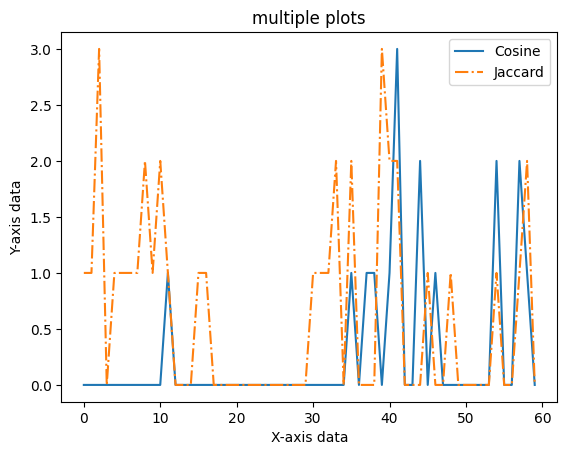

In [387]:
#grafik garis dari seluruh indeks
import numpy as np 
import matplotlib.pyplot as plt 
  
from matplotlib.pyplot import figure

y1 = int_df['MAE_Cos']
x =  range(0, 60)
y2 = int_df['MAE_Jac']
plt.plot(x, y1, label ='Cosine')
plt.plot(x, y2, '-.', label ='Jaccard')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('multiple plots')
plt.show()

#### visualisasi seluruh indeks rmse

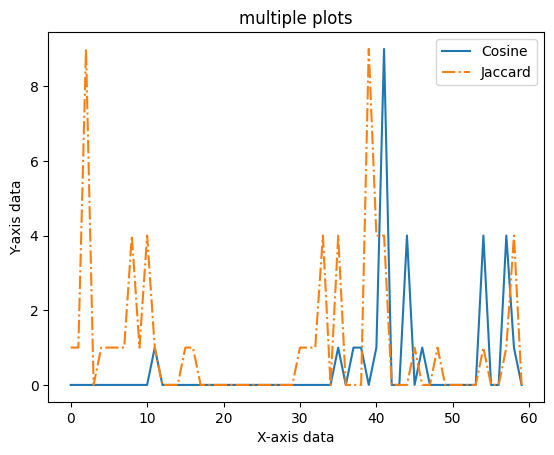

In [388]:
#grafik garis dari seluruh indeks
import numpy as np 
import matplotlib.pyplot as plt 
  
from matplotlib.pyplot import figure

y1 = int_df['MAE_Cos2']
x =  range(0, 60)
y2 = int_df['MAE_Jac2']
plt.plot(x, y1, label ='Cosine')
plt.plot(x, y2, '-.', label ='Jaccard')

plt.xlabel("X-axis data")
plt.ylabel("Y-axis data")
plt.legend()
plt.title('multiple plots')
plt.show()

#### visualisasi sama sama salah

[1, 1, 1, 3, 2, 2, 1]
[1, 2, 2, 2, 1, 1, 2]


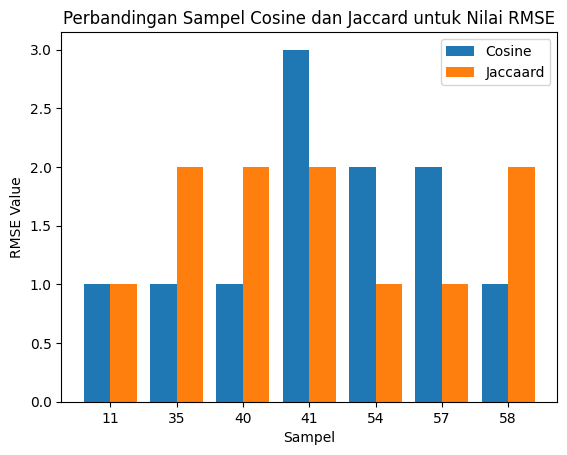

In [389]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = sama_sama_salah

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Perbandingan Sampel Cosine dan Jaccard untuk Nilai RMSE")
plt.legend()
plt.show()

#### Visualisasi cosine benar jaccard salah

In [390]:
jaccard_yang_salah

0      True
1      True
2     False
3     False
4      True
5      True
6      True
7      True
8     False
9      True
10    False
11     True
12    False
13    False
14    False
15     True
16     True
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40    False
41    False
42    False
43    False
44    False
45     True
46    False
47    False
48     True
49    False
50    False
51    False
52    False
53    False
54     True
55    False
56    False
57     True
58    False
59    False
Name: MAE_Jac, dtype: bool

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


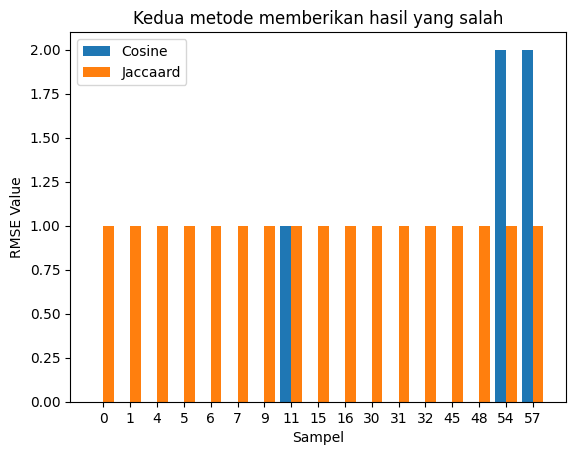

In [391]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = jaccard_yang_salah.index[jaccard_yang_salah].tolist()

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Kedua metode memberikan hasil yang salah")
plt.legend()
plt.show()

In [392]:
import numpy as np 
import matplotlib.pyplot as plt 


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center' )

X = jaccard_yang_salah

y1 = int_df.iloc[X]['MAE_Cos'].tolist()
y2 = int_df.iloc[X]['MAE_Jac'].tolist()

print(y1)
print(y2)

Cos = y1
Jac = y2
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Cos, 0.4, label = 'Cosine')
plt.bar(X_axis + 0.2, Jac, 0.4, label = 'Jaccaard')
  
  
plt.xticks(X_axis, X)
plt.xlabel("Sampel")
plt.ylabel("RMSE Value")
plt.title("Cosine Salah Jaccard Benar")
plt.legend()
plt.show()

NotImplementedError: iLocation based boolean indexing on an integer type is not available

#### Cosine Aja

In [ ]:
jaccard_yang_bener

[3,
 12,
 13,
 14,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 34,
 36,
 37,
 38,
 42,
 43,
 44,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 55,
 59]

In [ ]:
jaccard_yang_salah = int_df['MAE_Jac'] == 1
jaccard_yang_salah = jaccard_yang_salah.index[jaccard_yang_salah].tolist()

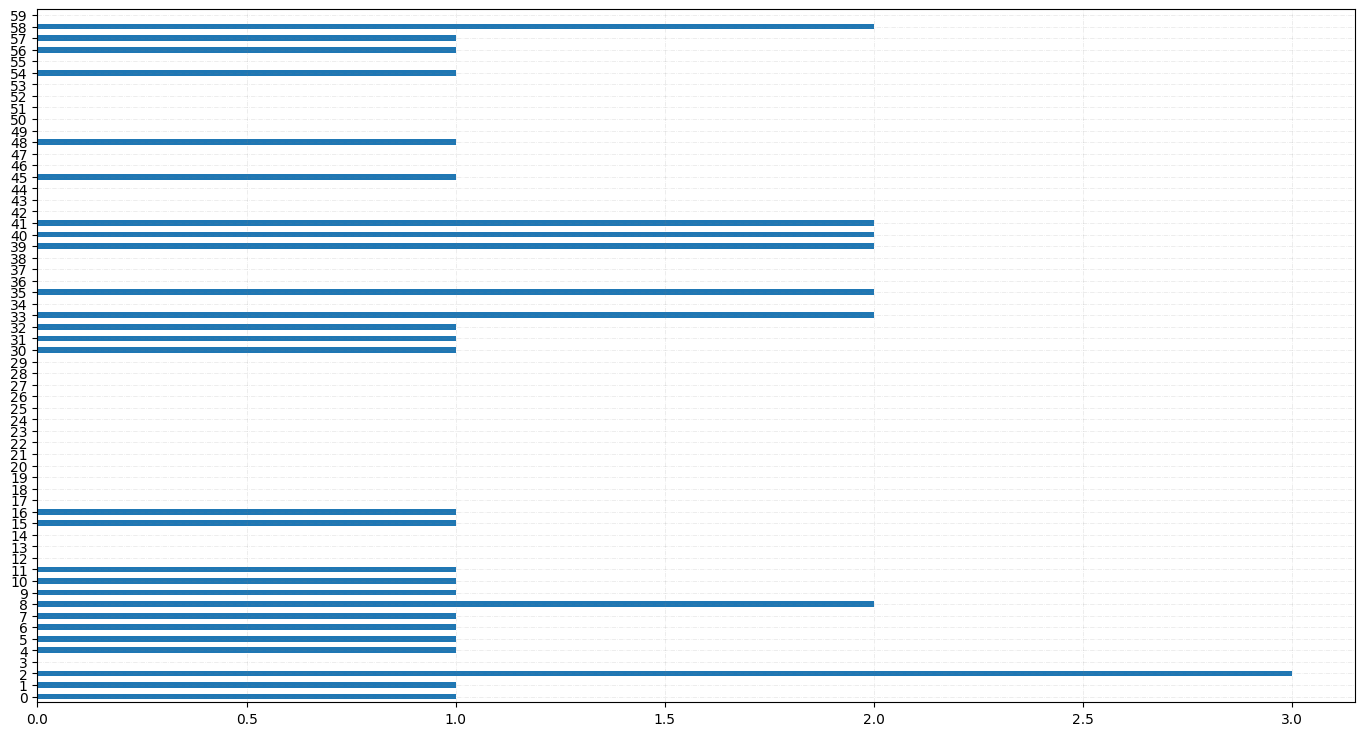

In [ ]:

X = int_df['MAE_Jac']
fig, ax = plt.subplots(figsize =(17, 9))
X.plot.barh()

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
plt.show()


TypeError: 'str' object is not callable

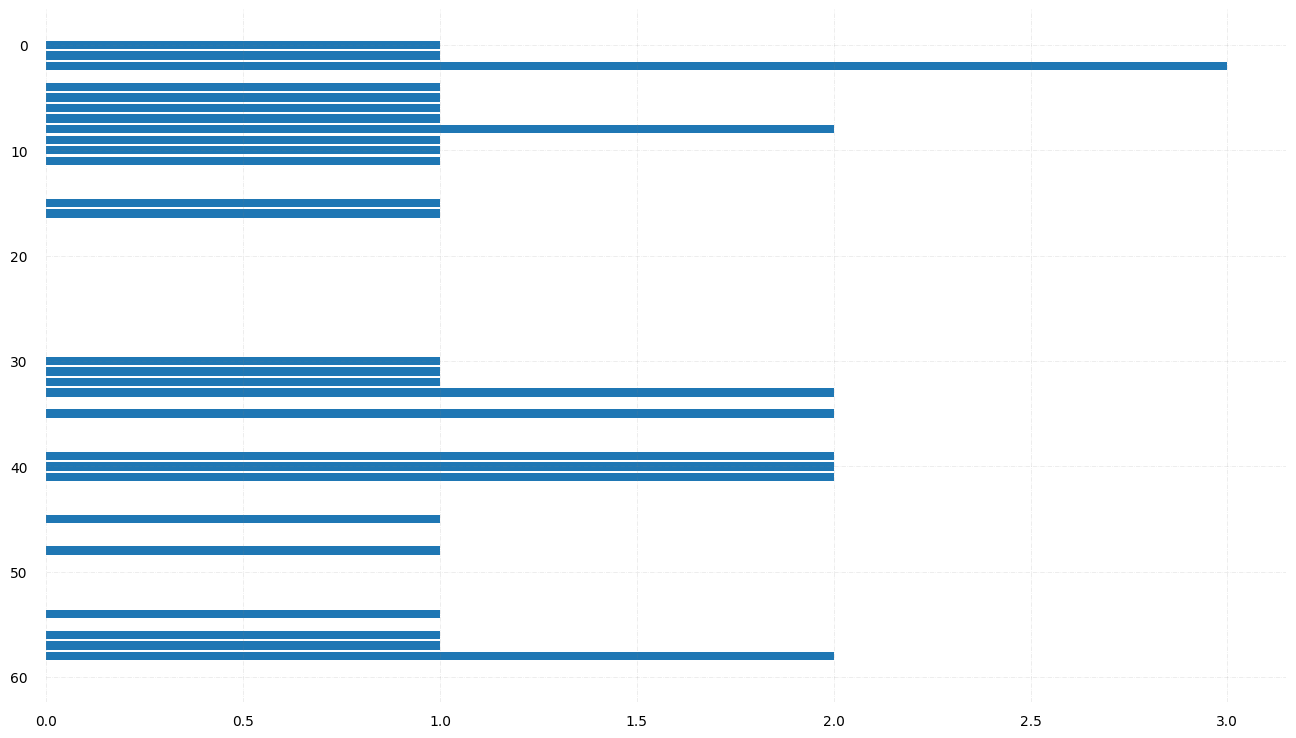

In [ ]:

 
name = X.index
price = X.values
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name, price)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Sports car and their price in crore',
             loc ='left', )
 
# Add Text watermark
fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()

# tembak 


In [ ]:

df_rekomendasi = pd.read_csv('hasilakhir.csv', delimiter=',')
df_rekomendasi.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,MAE_Cos2,MAE_Jac2
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[2, 3, 4, 5, 6]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]",[3 5 4 7 1],1,2,1,4
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[1, 3, 4, 5, 6]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]",[ 5 4 3 0 50],2,2,4,4
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[1, 2, 4, 5, 6]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]",[52 50 58 48 40],2,5,4,25
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[1, 2, 3, 5, 6]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]",[ 4 5 0 1 19],2,3,4,9
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[1, 2, 3, 4, 6]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]",[ 3 5 0 1 44],2,3,4,9


In [ ]:
df_rekomendasi.head()

,Index,Judul,Aktual,Deskripsi,Rubrik,Tag,Cossine Rekomend,Jaccard Recommned,MAE_Cos,MAE_Jac,MAE_Cos2,MAE_Jac2
0,0,"Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...","[2, 3, 4, 5, 6]",jelang ktt g menko luhut resmi plts apung mili...,Nasional,"plts terapung, energi baru terbarukan, PLN","[3, 5, 4, 1, 2]",[3 5 4 7 1],1,2,1,4
1,1,PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...,"[1, 3, 4, 5, 6]",pln hasil reduksi juta metrik ton emisi karbon...,Nasional,"reduksi, emisi karbon, PLN","[5, 3, 0, 4, 2]",[ 5 4 3 0 50],2,2,4,4
2,2,Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...,"[1, 2, 4, 5, 6]",instalasi pln pekon suoh masuk roadmap pln pas...,Nasional,"roadmap, instalasi, listrik, jaringan, PLN","[0, 3, 5, 1, 4]",[52 50 58 48 40],2,5,4,25
3,3,"Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...","[1, 2, 3, 5, 6]",jelang ktt g pln pamer plts pv rooftop bal pt ...,Nasional,"plts, g20, PLN","[0, 5, 4, 1, 2]",[ 4 5 0 1 19],2,3,4,9
4,4,"Jaga Pasokan Listrik KTT G20, PLN Operasikan P...","[1, 2, 3, 4, 6]",jaga pasok listrik ktt g pln operasi pltg relo...,Nasional,"pltg, g20, pasokan listrik, PLN","[3, 0, 5, 1, 2]",[ 3 5 0 1 44],2,3,4,9


In [ ]:
indices = pd.Series(df_rekomendasi.index, index=df_rekomendasi['Judul']).drop_duplicates()
indices

Judul
Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali                                              0
PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi Karbon di Tahun 2022                                                1
Instalasi PLN Dua Pekon di Suoh Masuk Roadmap PLN 2023                                                            2
Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 PV Rooftop di Bali                                                   3
Jaga Pasokan Listrik KTT G20, PLN Operasikan PLTG Relokasi Dari Grati ke Bali                                     4
Wujudkan Transisi Energi, PLN Siap Kerjakan Proyek PLTS Terapung Singkarak dan Saguling                           5
Mirota Kampus Buka Lowongan Kerja Bagian Operator Moulding, Simak Persyaratannya                                  6
BRI Kembali Buka Program Management Trainee, BRILiaN Future Leader Program                                        7
PT Petrolindo Megah Perkasa Buka Lowongan Kerja Bagi Lulusan D3, S

In [ ]:
df_rekomendasi['Judul'].iloc[x]


0     Jelang KTT G20, Menko Luhut Resmikan PLTS Tera...
1     PLN Berhasil Reduksi 32 Juta Metrik Ton Emisi ...
2     Instalasi PLN Dua Pekon di Suoh Masuk Roadmap ...
3     Jelang KTT G20, PLN Pamerkan Dua PLTS dan 33 P...
4     Jaga Pasokan Listrik KTT G20, PLN Operasikan P...
5     Wujudkan Transisi Energi, PLN Siap Kerjakan Pr...
6     Mirota Kampus Buka Lowongan Kerja Bagian Opera...
7     BRI Kembali Buka Program Management Trainee, B...
8     PT Petrolindo Megah Perkasa Buka Lowongan Kerj...
9     PT KAI Properti Buka Lowongan Kerja Bagian IT ...
10    Pertumbuhan Angkatan Kerja dan Lowongan Kerja ...
11       Bawaslu Tulang Bawang Buka Rekrutmen Panwascam
12    Muncul Dukungan Jokowi Jadi Ketum PDIP 2024, P...
13    Bepesan Agar Golkar Jangan Sembrono Pilih Capr...
14    Pesan Jokowi Saat Hadiri Acara Puncak HUT ke-5...
15    Dari Kapolri, Kapolda, Kapolresta dan Kapolres...
16    Panggil Pejabat Polri Tanpa Ajudan, Begini Pen...
17    Isu Hubungan Renggang Dengan Jokowi, Megaw

In [ ]:
import re
def Rekomen_Cos (title) :
    x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
    x = re.findall(r'\d+', x)
    x = df_rekomendasi['Judul'].iloc[x]
    return x

def Rekomen_Jac (title) :
    y = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
    y = re.findall(r'\d+', x)
    y = df_rekomendasi['Judul'].iloc[x]
    return y




In [ ]:
def Rekomen_Cos (title) :
    if title in indices:
        x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
        x = re.findall(r'\d+', x)
        x = list(map(int, x))
        x = df_rekomendasi['Judul'][x]
        return x
    else : return ("Tidak ada  berita seperti itu")
    

In [ ]:
x = [9,10,11]
df_rekomendasi['Judul'][x]

9     PT KAI Properti Buka Lowongan Kerja Bagian IT ...
10    Pertumbuhan Angkatan Kerja dan Lowongan Kerja ...
11       Bawaslu Tulang Bawang Buka Rekrutmen Panwascam
Name: Judul, dtype: object

In [ ]:
title = 'Melalui Matching Fund, UBL Riset Bersama PT Angkasa Wiratama'


In [ ]:
x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Cossine Rekomend'].values[0]
x = re.findall(r'\d+', x)
x = list(map(int, x))
x

[34, 33, 30, 31, 35]

In [ ]:
df2=df_rekomendasi[df_rekomendasi.index.isin(x)]
df2['Judul']

30    UBL Riset Bersama Diskominfotiksan Pemkab Pesa...
31    UBL Gelar Yudisium dan Wisuda Luluskan 631 Mah...
33    Melalui Program Matching Fund, UBL Riset Bersa...
34    UBL Riset Bersama PRTRRB - BRIN Rancang Bangun...
35    UBL Kembali Raih Penghargaan Universitas Terba...
Name: Judul, dtype: object

In [ ]:
title = 'Melalui Matching Fund, UBL Riset Bersama PT Angkasa Wiratama'
x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
#x = re.findall(r'\d+', x)
x

'[34 33 30 31  6]'

In [ ]:
def Rekomen_Jac (title) :
    if title in indices:    
        x = df_rekomendasi[df_rekomendasi['Judul'] == title]['Jaccard Recommned'].values[0]
        x = re.findall(r'\d+', x)
        x = res = [eval(i) for i in x]
        df2=df_rekomendasi[df_rekomendasi.index.isin(x)]
        y = df2['Judul'].tolist()
        return y
    else : return ("Tidak ada  berita seperti itu")


In [ ]:
title = 'Jelang KTT G20, Menko Luhut Resmikan PLTS Terapung Milik PLN di Bali'
x = Rekomen_Jac (title)



### notebook



In [ ]:
int_df.iloc[8]

Index                                                                8
Judul                PT Petrolindo Megah Perkasa Buka Lowongan Kerj...
Aktual                                               [6, 7, 9, 10, 11]
Deskripsi            pt petrolindo megah perkasa buka lowong kerja ...
Rubrik                                                  Lowongan kerja
Tag                  Loker PT Petrolindo, PT Petrolindo megah perka...
Cossine Rekomend                                     [9, 6, 11, 10, 7]
Jaccard Recommned                                    [6, 9, 7, 39, 33]
MAE_Cos                                                              0
MAE_Jac                                                              2
Error_Cosine                                                        []
Error_Jaccard                                                 [33, 39]
MAE_Cos2                                                             0
MAE_Jac2                                                             4
Name: 

In [ ]:
print(" ")
print(deskripsi[8])
print(" ")
print(deskripsi[33])
print(" ")





 
pt petrolindo megah perkasa buka lowong kerja lulus d simak syarat lulus d jurus teknik mesin teknik industri teknik elektro cari kerja simak lowong kerja pt petrolindo megah perkasa buka lowong kerja posisi tanggung operasional pt petrolindo megah perkasa buah usaha gerak bidang jual sewa rental awat parts pompa dewatering slurry usaha milik jaring nasional sebar daerah indonesia loker pt petrolindo pt petrolindo megah perkasa lowong bumn loker bumn lowong kerja
 
program matching fund ubl riset gmf aero asia universitas bandar lampung jalin kerjasama pt garuda maintenance facility gmf aero asia rancang robot pandu otomatis automatic guided vehicle agv awat pesawat terbang pt gmf aero asia rupa anak usaha garuda indonesia milik bisnis jasa awat periksa pesawat terbang riset robot pandu otomatis automatic guided vehicle agv giat riset rancang bangun agv laksana laboratorium mekatronika ubl kota bandar lampung pusat awat pesawat terbang pusat awat pesawat terbang pt gmf aero asia area

indeks perbedaan : 9, 14, 25, 31, 45, 46, 47